<font size=5 face='黑体'>1.正则表达式

In [7]:
import re
p = re.compile(r'(\w+) (\w+)')
s = 'i say, hello world'

print(p.sub(r'\2.title() \1.title()',s))
print(p.subn(r'\2.title() \1.title()',s))

def func(m):
    return m.group(1).title() + ' ' + m.group(2).title()

print(p.sub(func,s))
print(p.subn(func,s))

say.title() i.title(), world.title() hello.title()
('say.title() i.title(), world.title() hello.title()', 2)
I Say, Hello World
('I Say, Hello World', 2)


In [11]:
p = re.compile(r'l\w')
p.split(s)

['i say, he', 'o wor', '!']

In [6]:
p.findall(s)

['ll', 'ld']

In [13]:
for i in p.finditer(s):
    print(i.group())

ll
ld


In [10]:
p = re.compile(r'(\w+) (\w+).* (\w+ \w+)(?P<sign>.*)')
s = 'i say, hello world!'
m = p.match(s)
print(m.group(1,2))
print(m.groups())
print(m.pos)
print(m.endpos)
print(m.start(2))
print(m.end(2))
print(m.span(2))
print(m.expand(r'\3\4 \1\2'))

('i', 'say')
('i', 'say', 'hello world', '!')
0
19
2
5
(2, 5)
hello world! isay


<font size=5 face='黑体'>2.中文分词

In [15]:
import jieba

seg_list = jieba.cut('我在学习自然语言处理',cut_all=True)   #全模式
print('Full Mode：'+'/ '.join(seg_list))     

seg_list = jieba.cut('我在学习自然语言处理',cut_all=False)     #精确模式（默认）
print('Default Mode：'+'/ '.join(seg_list))

Full Mode：我/ 在/ 学习/ 自然/ 自然语言/ 语言/ 处理
Default Mode：我/ 在/ 学习/ 自然语言/ 处理


In [16]:
seg_list = jieba.cut('小明毕业于上海交通大学，毕业后在百度深度学习研究院深造')
print('/ '.join(seg_list))

seg_list = jieba.cut_for_search('小明毕业于上海交通大学，毕业后在百度深度学习研究院深造')    #搜索引擎模式
print('/ '.join(seg_list))

小明/ 毕业/ 于/ 上海交通大学/ ，/ 毕业/ 后/ 在/ 百度/ 深度/ 学习/ 研究院/ 深造
小明/ 毕业/ 于/ 上海/ 交通/ 大学/ 上海交通大学/ ，/ 毕业/ 后/ 在/ 百度/ 深度/ 学习/ 研究/ 研究院/ 深造


In [17]:
#用户添加自定义词典
#jieba.load_userdict(file_name)
#jieba.add_word 和 jieba.del_word
#jieba.suggest_freq（segment,tune=True）可以调节单个词语的词频
#（注意需要将HMM设为False）
print('/ '.join(jieba.cut('如果放到旧词典中将出错')))
jieba.suggest_freq(('中','将'),True)
print('/ '.join(jieba.cut('如果放到旧词典中将出错',HMM=False)))

如果/ 放到/ 旧/ 词典/ 中将/ 出错
如果/ 放到/ 旧/ 词典/ 中/ 将/ 出错


In [18]:
#关键词提取
#基于TF-IDF的关键词提取
#jieba.analyse.extract_tags()

In [ ]:
#基于TextRank算法的关键词提取   适合大样本
#jieba.analyse.textrank()

In [19]:
#词性标注
import jieba.posseg as pseg
words = pseg.cut('我爱自然语言处理')
for word,flag in words:
    print('%s %s' % (word,flag))

我 r
爱 v
自然语言 l
处理 v


<font size=5 face='黑体'>3.文本分类

<font size=5 face='黑体'>朴素贝叶斯新闻分类

In [68]:
import os
import time
import random
import jieba
#import nltk   处理英文
import sklearn
from sklearn.naive_bayes import MultinomialNB
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt

#读取停止词文件
def make_word_set(words_file):
    words_set = set()
    with open(words_file,'r',encoding='UTF-8') as fp:
        for line in fp.readlines():
            word = line.strip()
            if len(word)>0 and word not in words_set:
                words_set.add(word)
    return words_set

#文本处理，也就是样本生成过程
def text_processing(folder_path,test_size=0.2):
    folder_list = os.listdir(folder_path)
    data_list = []
    class_list = []
    
    #遍历文件夹
    for folder in folder_list:
        new_folder_path = os.path.join(folder_path,folder)
        files = os.listdir(new_folder_path)
        #读取文件
        for file in files:
            with open(os.path.join(new_folder_path,file),'r',encoding='UTF-8') as fp:
                raw = fp.read()
            word_cut = jieba.cut(raw,cut_all=False)  #精确模式
            word_list = list(word_cut)   #genertor转化为list,每个词是unicode格式
            
            data_list.append(word_list)
            class_list.append(folder)
    
    #划分训练集和测试集
    random.seed(10)
    data_class_list = list(zip(data_list,class_list))
    random.shuffle(data_class_list)
    index = int(len(data_class_list) * test_size) + 1
    train_list = data_class_list[index:]
    test_list = data_class_list[:index]
    train_data_list,train_class_list = zip(*train_list)
    test_data_list,test_class_list = zip(*test_list)
    
    #或者直接用train_test_split做
    
    #统计词频放入all_words_dict
    all_words_dict = {}
    for word_list in train_data_list:
        for word in word_list:
            if word in all_words_dict:
                all_words_dict[word] += 1
            else:
                all_words_dict[word] = 1
    
    #词频降序排序
    all_words_tuple_list = sorted(all_words_dict.items(),key=lambda x:x[1],reverse=True)
    all_words_list = list(list(zip(*all_words_tuple_list))[0])
    
    return all_words_list,train_data_list,test_data_list,train_class_list,test_class_list

#选取特征词
def words_dict(all_words_list,deleteN,stopwords_set=set()):
    feature_words = []
    n = 1
    for t in range(deleteN,len(all_words_list),1):
        if n > 2000:
            break
        if not all_words_list[t].isdigit() and all_words_list[t] not in stopwords_set and 1<len(all_words_list[t])<5:
            feature_words.append(all_words_list[t])
            n += 1
    return feature_words

#文本特征
def text_features(train_data_list,test_data_list,feature_words,flag='nltk'):
    def text_feature(text,feature_words):
        text_words = set(text)
        if flag == 'nltk':
            #nltk特征 dict
            features = {word:1 if word in text_words else 0 for word in feature_words}
        elif flag == 'sklearn':
            #sklearn特征 list
            features = [1 if word in text_words else 0 for word in feature_words]
        else:
            features = []
        return features
    
    train_feature_list = [text_feature(text,feature_words) for text in train_data_list]
    test_feature_list = [text_feature(text,feature_words) for text in test_data_list]
    
    return train_feature_list,test_feature_list

#分类，同时输出准确率等
def text_classifier(train_feature_list,test_feature_list,train_class_list,test_class_list,flag='nltk'):
    if flag == 'nltk':
        #使用nltk分类器
        train_flist = zip(train_feature_list,train_class_list)
        test_flist = zip(test_feature_list,test_class_list)
        classifier = nltk.classify.NaiveBayesClassifier.train(train_flist)
        test_accuracy = nltk.classify.accuracy(classifier,test_flist)
    elif flag == 'sklearn':
        #使用sklearn分类器
        classifier = MultinomialNB().fit(train_feature_list,train_class_list)
        test_accuracy = classifier.score(test_feature_list,test_class_list)
    else:
        test_accuracy = []
        
    return test_accuracy


print('start...')

# 文本预处理
folder_path = r'F:\百度网盘\NLP课件资料\Lecture_2\Lecture_2\Naive-Bayes-Text-Classifier\Database\SogouC\Sample'
all_words_list,train_data_list,test_data_list,train_class_list,test_class_list = text_processing(folder_path,test_size=0.2)

#生成stopwords_set
stopwords_file = r'F:\百度网盘\NLP课件资料\Lecture_2\Lecture_2\Naive-Bayes-Text-Classifier\stopwords_cn.txt'
stopwords_set = make_word_set(stopwords_file)

# 文本特征提取和分类
# flag = 'nltk'
flag = 'sklearn'
#deleteNs = range(0,200,20)
test_accuracy_list = []
#for deleteN in deleteNs:
feature_words = words_dict(all_words_list,0,stopwords_set)
#print(feature_words)
train_feature_list,test_feature_list = text_features(train_data_list,test_data_list,feature_words,flag)
test_accuracy = text_classifier(train_feature_list,test_feature_list,train_class_list,test_class_list,flag)
test_accuracy_list.append(test_accuracy)
    
print(test_accuracy_list)
print('finish')

start...
[0.8421052631578947]
finish


In [70]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

def text_processing(folder_path,test_size=0.2):
    folder_list = os.listdir(folder_path)
    data_list = []
    class_list = []
    
    #遍历文件夹
    for folder in folder_list:
        new_folder_path = os.path.join(folder_path,folder)
        files = os.listdir(new_folder_path)
        #读取文件
        for file in files:
            with open(os.path.join(new_folder_path,file),'r',encoding='UTF-8') as fp:
                raw = fp.read()
            word_cut = jieba.cut(raw,cut_all=False)  #精确模式
            word_cut = ' '.join(word_cut)
            #word_list = list(word_cut)   #genertor转化为list,每个词是unicode格式
            
            data_list.append(word_cut)
            class_list.append(folder)
    
    #划分训练集和测试集
    random.seed(10)
    data_class_list = list(zip(data_list,class_list))
    random.shuffle(data_class_list)
    index = int(len(data_class_list) * test_size) + 1
    train_list = data_class_list[index:]
    test_list = data_class_list[:index]
    train_data_list,train_class_list = zip(*train_list)
    test_data_list,test_class_list = zip(*test_list)
    
    #或者直接用train_test_split做
    
    return train_data_list,test_data_list,train_class_list,test_class_list

stopwords_file = r'F:\百度网盘\NLP课件资料\Lecture_2\Lecture_2\Naive-Bayes-Text-Classifier\stopwords_cn.txt'
stopwords_set = make_word_set(stopwords_file)

folder_path = r'F:\百度网盘\NLP课件资料\Lecture_2\Lecture_2\Naive-Bayes-Text-Classifier\Database\SogouC\Sample'
train_data_list,test_data_list,train_class_list,test_class_list = text_processing(folder_path,test_size=0.2)

y_train = train_class_list
y_test = test_class_list
vectorizer = TfidfVectorizer(input='content',token_pattern=r'(?u)\b\w+\b',stop_words=stopwords_set,max_df=0.5,sublinear_tf=True)
x_train = vectorizer.fit_transform(train_data_list)
x_test = vectorizer.transform(test_data_list)

print(u'训练集样本个数：%d,特征个数:%d' % x_train.shape)

alpha_can = np.logspace(-3,2,10)
model = GridSearchCV(MultinomialNB(),param_grid={'alpha':alpha_can},cv=5)
model.fit(x_train,y_train)
print('最优超参数为:',model.best_params_)
y_hat = model.predict(x_test)
acc = metrics.accuracy_score(y_test,y_hat)
print('测试集准确率: %.2f%%' % (100 * acc))

训练集样本个数：71,特征个数:9956
最优超参数为: {'alpha': 0.046415888336127795}
测试集准确率: 84.21%


<font size=5 face='黑体'>朴素贝叶斯语种检测

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
import re

#使用正则表达式 去除噪声数据
def remove_noise(document):
    noise_pattern = re.compile('|'.join(['http\S+','\@\w+','\#\w+']))   #'\'表示 或
    clean_text = re.sub(noise_pattern,'',document)
    return clean_text.strip()

#加载数据
def data_processing(path):
    with open(path,'r',encoding='UTF-8') as f:
        lines = f.readlines()
    dataset = [(line.strip()[:-3],line.strip()[-2:]) for line in lines]
    
    x,y = zip(*dataset)
    x_train,x_test,y_train,y_test = train_test_split(x,y,random_state=1)
    return x_train,x_test,y_train,y_test

path = r'F:\百度网盘\NLP课件资料\Lecture_2\Lecture_2\Language-Detector\data.csv'
x_train,x_test,y_train,y_test = data_processing(path)

vec = CountVectorizer(
    lowercase = True,
    analyzer = 'char_wb',
    ngram_range = (1,2),
    max_features = 1000,
    preprocessor = remove_noise)
vec.fit(x_train)

classifier = MultinomialNB()
classifier.fit(vec.transform(x_train),y_train)
print('准确率：',classifier.score(vec.transform(x_test),y_test))

准确率： 0.9770621967357741


In [ ]:
import keras
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

max_features = 10000
maxlen = 500

(x_train,y_train),(x_test,y_test) = imdb.load_data(num_words=max_features)
x_train = sequence.pad_sequences(x_train,maxlen=maxlen)
x_test = sequence.pad_sequences(x_test,maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features,64))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1,activation='sigmoid'))

model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])
history = model.fit(x_train,y_train,epochs=10,batch_size=128,validation_split=0.2)

In [ ]:
from keras.datasets import imdb

(x_train,y_train),(x_test,y_test) = imdb.load_data(num_words=10000)

H:\anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of 599dadb1135973df5b59232a0e9a887c so we will re-download the data.


In [1]:
import os

imdb_dir = r'D:\aclImdb_v1\aclImdb'
train_dir = os.path.join(imdb_dir,'train')
test_dir = os.path.join(imdb_dir,'test')

train_labels = []
test_labels = []
train_texts = []
test_texts = []

for label_type in ['neg','pos']:
    dir_name_train = os.path.join(train_dir,label_type)
    for fname in os.listdir(dir_name_train):
        if fname[-4:] == '.txt':
            with open(os.path.join(dir_name_train,fname),'r',encoding='utf8') as fp:
                train_texts.append(fp.read())
            if label_type == 'neg':
                train_labels.append(0)
            else:
                train_labels.append(1)
    dir_name_test = os.path.join(test_dir,label_type)
    for fname in os.listdir(dir_name_test):
        if fname[-4:] == '.txt':
            with open(os.path.join(dir_name_test,fname),'r',encoding='utf8') as fp:
                test_texts.append(fp.read())
            if label_type == 'neg':
                test_labels.append(0)
            else:
                test_labels.append(1)
                
                
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
from keras import layers
from keras.models import Sequential

maxlen = 200
#training_sample = 200
#validation_samples = 10000
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_texts)
sequences_train = tokenizer.texts_to_sequences(train_texts)
sequences_test = tokenizer.texts_to_sequences(test_texts)

#word_index = tokenizer.word_index
x_train = pad_sequences(sequences_train,maxlen=maxlen)
y_train = np.asarray(train_labels)

x_test = pad_sequences(sequences_test,maxlen=maxlen)
y_test = np.asarray(test_labels)

model = Sequential()
model.add(layers.Embedding(10000,64))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1,activation='sigmoid'))

model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])
history = model.fit(x_train,y_train,epochs=10,batch_size=128,validation_split=0.2)

model.evaluate(x_test,y_test)

H:\anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 173s 9ms/step - loss: 0.4877 - acc: 0.7661 - val_loss: 0.3639 - val_acc: 0.9078
Epoch 2/10
20000/20000 [==============================] - 159s 8ms/step - loss: 0.2957 - acc: 0.8848 - val_loss: 0.5905 - val_acc: 0.7788
Epoch 3/10
20000/20000 [==============================] - 167s 8ms/step - loss: 0.2451 - acc: 0.9071 - val_loss: 1.0561 - val_acc: 0.6088
Epoch 4/10
20000/20000 [==============================] - 159s 8ms/step - loss: 0.2034 - acc: 0.9271 - val_loss: 1.3799 - val_acc: 0.5702
Epoch 5/10
20000/20000 [==============================] - 161s 8ms/step - loss: 0.1779 - acc: 0.9376 - val_loss: 1.1418 - val_acc: 0.6416
Epoch 6/10
20000/20000 [==============================] - 161s 8ms/step - loss: 0.1550 - acc: 0.9470 - val_loss: 0.4538 - val_acc: 0.8504
Epoch 7/10
20000/20000 [==============================] - 161s 8ms/step - loss: 0.1380 - acc: 0.9526 - val_loss: 0.2808 - v

[0.40751714597463606, 0.85244]

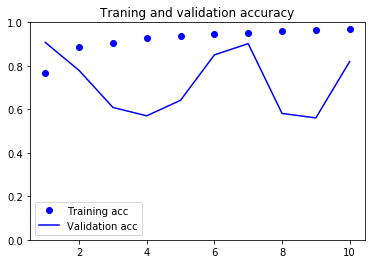

In [5]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1,len(acc)+1)
plt.plot(epochs,acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'b',label='Validation acc')
plt.title('Traning and validation accuracy')
plt.legend()
plt.ylim(0,1)
plt.show()


Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 449s 22ms/step - loss: 0.5045 - acc: 0.7487 - val_loss: 0.8442 - val_acc: 0.6932
Epoch 2/10
20000/20000 [==============================] - 450s 22ms/step - loss: 0.3204 - acc: 0.8724 - val_loss: 0.2757 - val_acc: 0.8974
Epoch 3/10
20000/20000 [==============================] - 443s 22ms/step - loss: 0.2462 - acc: 0.9047 - val_loss: 1.1192 - val_acc: 0.6004
Epoch 4/10
20000/20000 [==============================] - 394s 20ms/step - loss: 0.2029 - acc: 0.9254 - val_loss: 0.2227 - val_acc: 0.9278
Epoch 5/10
20000/20000 [==============================] - 394s 20ms/step - loss: 0.1768 - acc: 0.9345 - val_loss: 1.6101 - val_acc: 0.5392
Epoch 6/10
20000/20000 [==============================] - 429s 21ms/step - loss: 0.1527 - acc: 0.9479 - val_loss: 0.3436 - val_acc: 0.8772
Epoch 7/10
20000/20000 [==============================] - 418s 21ms/step - loss: 0.1349 - acc: 0.9556 - val_loss: 0.8

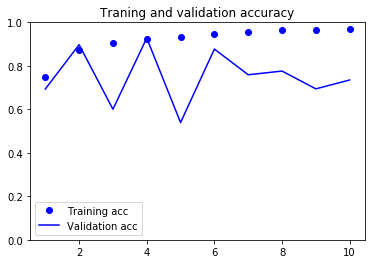

In [6]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
from keras import layers
from keras.models import Sequential

maxlen = 500
#training_sample = 200
#validation_samples = 10000
max_words = 12000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_texts)
sequences_train = tokenizer.texts_to_sequences(train_texts)
sequences_test = tokenizer.texts_to_sequences(test_texts)

#word_index = tokenizer.word_index
x_train = pad_sequences(sequences_train,maxlen=maxlen)
y_train = np.asarray(train_labels)

x_test = pad_sequences(sequences_test,maxlen=maxlen)
y_test = np.asarray(test_labels)

model = Sequential()
model.add(layers.Embedding(12000,64))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1,activation='sigmoid'))

model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])
history = model.fit(x_train,y_train,epochs=10,batch_size=128,validation_split=0.2)

model.evaluate(x_test,y_test)

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1,len(acc)+1)
plt.plot(epochs,acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'b',label='Validation acc')
plt.title('Traning and validation accuracy')
plt.legend()
plt.ylim(0,1)
plt.show()